# CHEERS Ram-Mohan et al.

**Created**: 25 March 2022

I ran my version of CHEERS on the following set of SNPs. In all cases, I included the lead SNP and any tagging SNPs ($R^2 > 0.8$).

1. Lead eSNPs from Initial cis-eQTL Mapping
2. Conditional eSNPs from cis-eQTL Mapping
3. Conditional eSNPs that represent non-primary signals from the cis-eQTL Mapping
3. Lead eSNPs that are sepsis-specific based on Katie's mashR analysis
4. Lead eSNPs that are sepsis-specific and stronger in GAInS based on Katie's mashR analysis
5. Lead eSNPs that are NOT sepsis-specific based on Katie's mashR analysis

## Environment

In [61]:
if (!requireNamespace("patchwork")) {
    install.packages("devtools")
    devtools::install_github("thomasp85/patchwork")
}

if (!requireNamespace("ComplexHeatmap", quietly=TRUE)) {
    BiocManager::install("ComplexHeatmap")
}

In [62]:
library(tidyverse)
library(patchwork)
library(ComplexHeatmap)
library(data.table)

setwd("~/eQTL_pQTL_Characterization/")

source("03_Functional_Interpretation/scripts/utils/ggplot_theme.R")

## Specific Stimulations

### Load Data

In [63]:
lead.effects <- read.table(
    "~/gains_team282/epigenetics/enrichment/cheers/lead_snps_ld_disease_enrichment_observedMeanRank.txt",
    col.names=c("Condition", "Rank.Mean")
)
conditional.effects <- read.table(
     "~/gains_team282/epigenetics/enrichment/cheers/conditional_snps_ld_disease_enrichment_observedMeanRank.txt",
    col.names=c("Condition", "Rank.Mean")
)
conditional.secondary.effects <- read.table(
     "~/gains_team282/epigenetics/enrichment/cheers/conditional_secondary_snps_ld_disease_enrichment_observedMeanRank.txt",
    col.names=c("Condition", "Rank.Mean")
)
non.sepsis.effects <- read.table(
     "~/gains_team282/epigenetics/enrichment/cheers/non_sepsis_snps_ld_disease_enrichment_observedMeanRank.txt",
    col.names=c("Condition", "Rank.Mean")
)
sepsis.effects <- read.table(
     "~/gains_team282/epigenetics/enrichment/cheers/sepsis_snps_ld_disease_enrichment_observedMeanRank.txt", 
    col.names=c("Condition", "Rank.Mean")
)
sepsis.up.effects <- read.table(
     "~/gains_team282/epigenetics/enrichment/cheers/sepsis_up_snps_ld_disease_enrichment_observedMeanRank.txt",
    col.names=c("Condition", "Rank.Mean")
)

In [64]:
lead.p.vals <- read.table("~/gains_team282/epigenetics/enrichment/cheers/lead_snps_ld_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))
conditional.p.vals <- read.table("~/gains_team282/epigenetics/enrichment/cheers/conditional_snps_ld_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))
conditional.secondary.p.vals <- read.table("~/gains_team282/epigenetics/enrichment/cheers/conditional_secondary_snps_ld_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))
non.sepsis.p.vals <- read.table("~/gains_team282/epigenetics/enrichment/cheers/non_sepsis_snps_ld_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))
sepsis.p.vals <- read.table("~/gains_team282/epigenetics/enrichment/cheers/sepsis_snps_ld_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))
sepsis.up.p.vals <- read.table("~/gains_team282/epigenetics/enrichment/cheers/sepsis_up_snps_ld_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))

In [65]:
lead.summary <- read.table("~/gains_team282/epigenetics/enrichment/cheers/lead_snps_ld.log", sep="\t")
conditional.summary <- read.table("~/gains_team282/epigenetics/enrichment/cheers/conditional_snps_ld.log", sep="\t")
conditional.secondary.summary <- read.table("~/gains_team282/epigenetics/enrichment/cheers/conditional_secondary_snps_ld.log", sep="\t")
non.sepsis.summary <- read.table("~/gains_team282/epigenetics/enrichment/cheers/non_sepsis_snps_ld.log", sep="\t")
sepsis.summary <- read.table("~/gains_team282/epigenetics/enrichment/cheers/sepsis_snps_ld.log", sep="\t")
sepsis.up.summary <- read.table("~/gains_team282/epigenetics/enrichment/cheers/sepsis_up_snps_ld.log", sep="\t")

The Bonferroni-adjusted significance is adjusted based on the number of samples tested against (`nrow(lead.p.vals)`), the number of SNP lists tested (6), and the number of times the testing is done (2).

In [66]:
critical.value <- qnorm(0.05 / (nrow(lead.p.vals) * 6 * 2), lower.tail=F)

In [67]:
stat.info <- data.frame(
    SNPs=c("Lead cis-eQTL", "Conditional cis-eQTL", "Conditional Secondary cis-eQTL", "Non-Sepsis-Specific cis-eQTL", "Sepsis-Specific cis-eQTL", "Sepsis-Specific Up cis-eQTL"),
    Mean=c(lead.summary[4,2], conditional.summary[4,2], conditional.secondary.summary[4,2], non.sepsis.summary[4,2], sepsis.summary[4,2], sepsis.up.summary[4,2]),
    SD=c(lead.summary[5,2], conditional.summary[5,2], conditional.secondary.summary[5,2], non.sepsis.summary[5,2], sepsis.summary[5,2], sepsis.up.summary[5,2])
)

head(stat.info)

,SNPs,Mean,SD
,<chr>,<dbl>,<dbl>
1,Lead cis-eQTL,145598,957.6502
2,Conditional cis-eQTL,145598,844.1599
3,Conditional Secondary cis-eQTL,145598,1415.8383
4,Non-Sepsis-Specific cis-eQTL,145598,1053.6442
5,Sepsis-Specific cis-eQTL,145598,1803.2809
6,Sepsis-Specific Up cis-eQTL,145598,3077.6829


In [68]:
effects <- dplyr::bind_rows(
    lead.effects %>% dplyr::mutate(SNPs="Lead cis-eQTL"),
    conditional.effects %>% dplyr::mutate(SNPs="Conditional cis-eQTL"),
    conditional.secondary.effects %>% dplyr::mutate(SNPs="Conditional Secondary cis-eQTL"),
    non.sepsis.effects %>% dplyr::mutate(SNPs="Non-Sepsis-Specific cis-eQTL"),
    sepsis.effects %>% dplyr::mutate(SNPs="Sepsis-Specific cis-eQTL"),
    sepsis.up.effects %>% dplyr::mutate(SNPs="Sepsis-Specific Up cis-eQTL")
)

head(effects)

,Condition,Rank.Mean,SNPs
,<chr>,<dbl>,<chr>
1,LTA,145474.9,Lead cis-eQTL
2,LPS,122083.6,Lead cis-eQTL
3,FLAG,172894.1,Lead cis-eQTL
4,R848,166054.7,Lead cis-eQTL
5,BGP,143648.4,Lead cis-eQTL
6,HMGB1,154943.6,Lead cis-eQTL


In [69]:
p.vals <- dplyr::bind_rows(
    lead.p.vals %>% dplyr::mutate(SNPs="Lead cis-eQTL"),
    conditional.p.vals %>% dplyr::mutate(SNPs="Conditional cis-eQTL"),
    conditional.secondary.p.vals %>% dplyr::mutate(SNPs="Conditional Secondary cis-eQTL"),
    non.sepsis.p.vals %>% dplyr::mutate(SNPs="Non-Sepsis-Specific cis-eQTL"),
    sepsis.p.vals %>% dplyr::mutate(SNPs="Sepsis-Specific cis-eQTL"),
    sepsis.up.p.vals %>% dplyr::mutate(SNPs="Sepsis-Specific Up cis-eQTL")
)

head(p.vals)

,Condition,P.Value,SNPs
,<chr>,<dbl>,<chr>
1,LTA,0.5511406,Lead cis-eQTL
2,LPS,1.0000000,Lead cis-eQTL
3,FLAG,0.0000000,Lead cis-eQTL
4,R848,0.0000000,Lead cis-eQTL
5,BGP,0.9791164,Lead cis-eQTL
6,HMGB1,0.0000000,Lead cis-eQTL


### Enrichment of Different SNP Lists

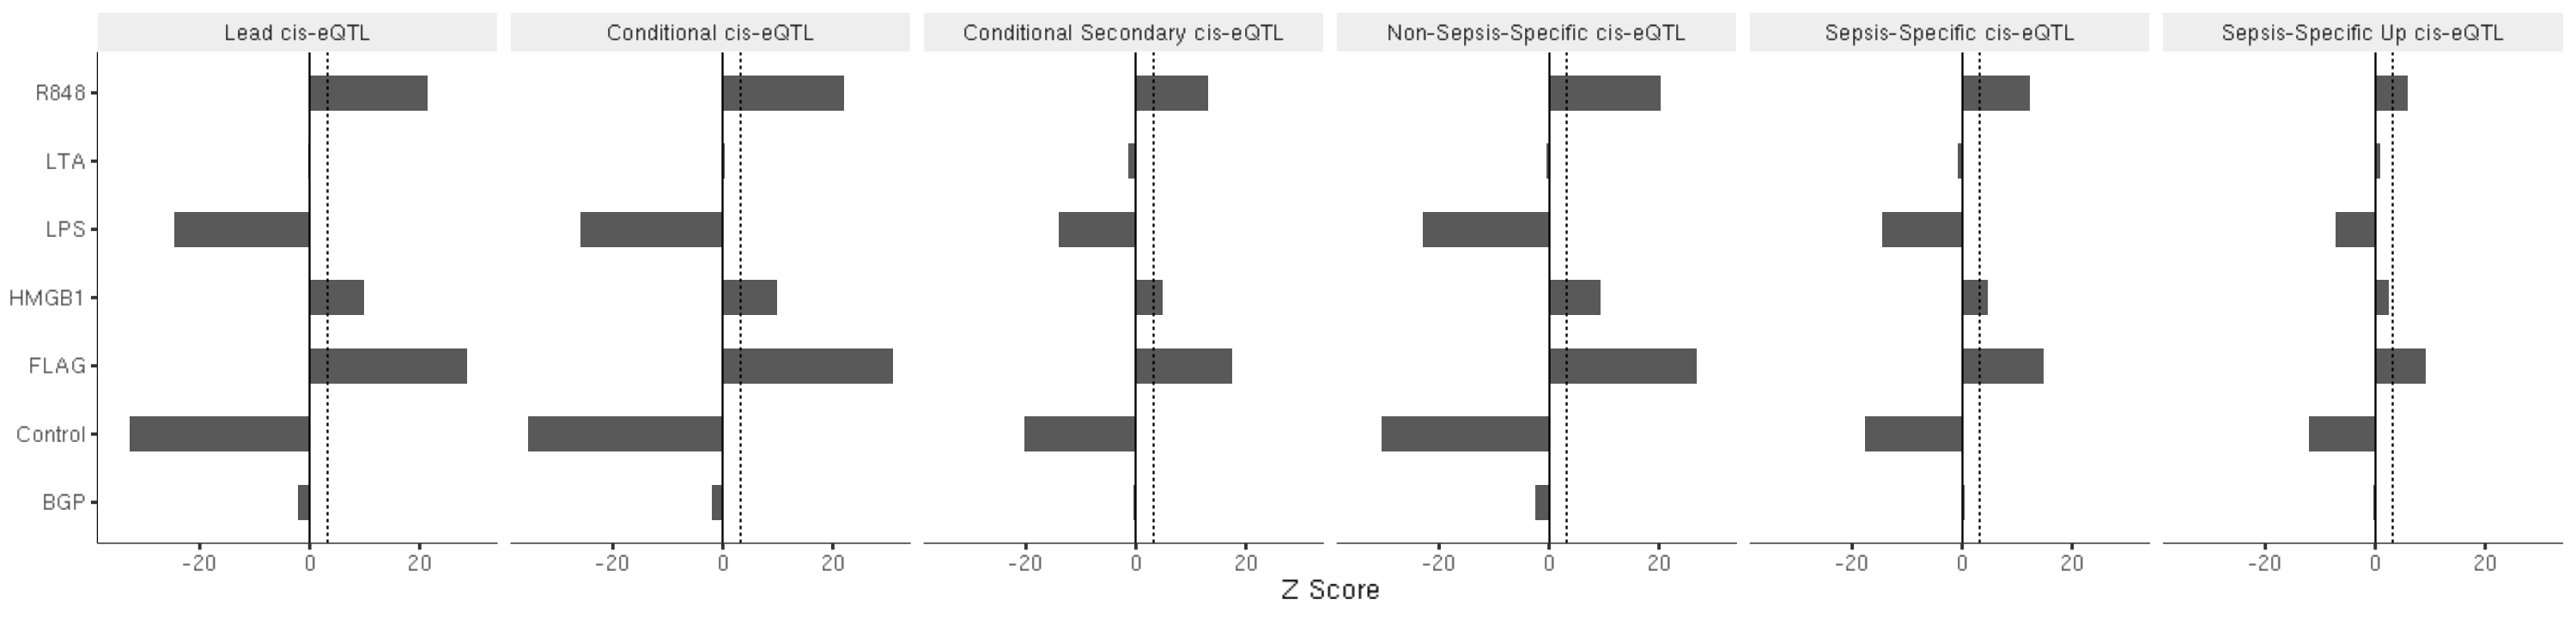

In [70]:
options(repr.plot.width=25, repr.plot.height=6)

merge(effects, p.vals, by=c("SNPs", "Condition")) %>%
    merge(., stat.info, by="SNPs") %>%
    dplyr::mutate(SNPs=factor(SNPs, levels=c("Lead cis-eQTL", "Conditional cis-eQTL", "Conditional Secondary cis-eQTL", "Non-Sepsis-Specific cis-eQTL", "Sepsis-Specific cis-eQTL", "Sepsis-Specific Up cis-eQTL"))) %>%
    dplyr::mutate(Z=(Rank.Mean - Mean) / SD) %>%
    ggplot() + 
    geom_bar(aes(x=Condition, y=Z), stat="identity", width=0.5) +
    geom_hline(aes(yintercept=critical.value), lty=2) +
    geom_hline(aes(yintercept=0)) +
    facet_grid(. ~ SNPs, scale="free_y", space="free_y") +
    scale_fill_brewer(palette="Pastel1") +
    coord_flip() +
    ylab("Z Score") +
    ggplot_theme +
    theme(axis.title.y=element_blank(), strip.text.y=element_text(angle=0))

ggsave("03_Functional_Interpretation/results/cheers_ram_mohan_et_al_all.svg", width=25, height=6)

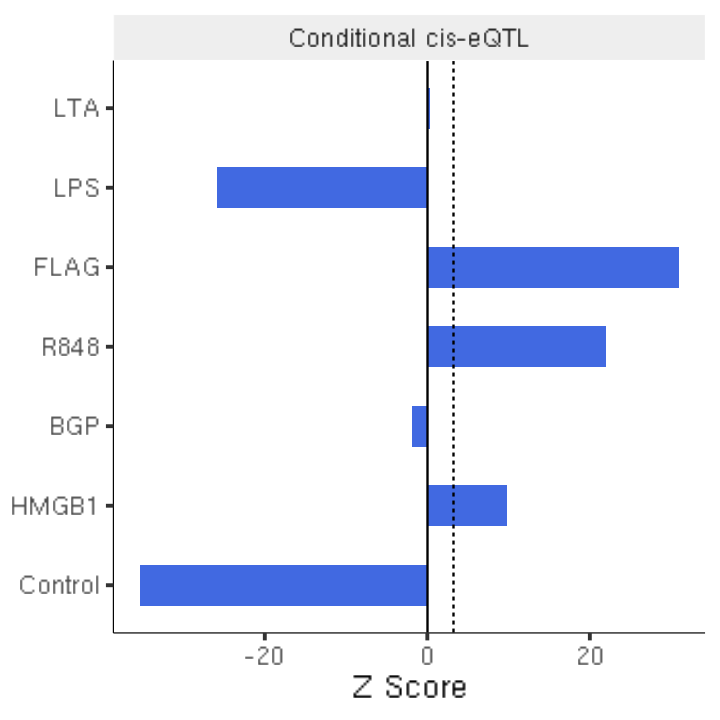

In [72]:
options(repr.plot.width=6, repr.plot.height=6)

merge(effects, p.vals, by=c("SNPs", "Condition")) %>%
    merge(., stat.info, by="SNPs") %>%
    dplyr::filter(SNPs == "Conditional cis-eQTL") %>%
    dplyr::mutate(Condition=factor(Condition, levels=rev(c("LTA", "LPS", "FLAG", "R848", "BGP", "HMGB1", "Control")))) %>%
    dplyr::mutate(Z=(Rank.Mean - Mean) / SD) %>%
    ggplot() + 
    geom_bar(aes(x=Condition, y=Z), stat="identity", width=0.5, fill="royalblue") +
    geom_hline(aes(yintercept=critical.value), lty=2) +
    geom_hline(aes(yintercept=0)) +
    facet_grid(. ~ SNPs, scale="free_y", space="free_y") +
    scale_fill_brewer(palette="Pastel1") +
    coord_flip() +
    ylab("Z Score") +
    ggplot_theme +
    theme(axis.title.y=element_blank(), strip.text.y=element_text(angle=0))

ggsave("03_Functional_Interpretation/results/cheers_ram_mohan_et_al_conditional.svg", width=6, height=6)

## Whole Organism Stimulation

### Load Data

In [48]:
lead.effects <- read.table(
    "~/gains_team282/epigenetics/enrichment/cheers/lead_snps_ld_WB_disease_enrichment_observedMeanRank.txt",
    col.names=c("Condition", "Rank.Mean")
)
conditional.effects <- read.table(
     "~/gains_team282/epigenetics/enrichment/cheers/conditional_snps_ld_WB_disease_enrichment_observedMeanRank.txt",
    col.names=c("Condition", "Rank.Mean")
)
conditional.secondary.effects <- read.table(
     "~/gains_team282/epigenetics/enrichment/cheers/conditional_secondary_snps_ld_WB_disease_enrichment_observedMeanRank.txt",
    col.names=c("Condition", "Rank.Mean")
)
non.sepsis.effects <- read.table(
     "~/gains_team282/epigenetics/enrichment/cheers/non_sepsis_snps_ld_WB_disease_enrichment_observedMeanRank.txt",
    col.names=c("Condition", "Rank.Mean")
)
sepsis.effects <- read.table(
     "~/gains_team282/epigenetics/enrichment/cheers/sepsis_snps_ld_WB_disease_enrichment_observedMeanRank.txt", 
    col.names=c("Condition", "Rank.Mean")
)
sepsis.up.effects <- read.table(
     "~/gains_team282/epigenetics/enrichment/cheers/sepsis_up_snps_ld_WB_disease_enrichment_observedMeanRank.txt",
    col.names=c("Condition", "Rank.Mean")
)

In [50]:
lead.p.vals <- read.table("~/gains_team282/epigenetics/enrichment/cheers/lead_snps_ld_WB_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))
conditional.p.vals <- read.table("~/gains_team282/epigenetics/enrichment/cheers/conditional_snps_ld_WB_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))
conditional.secondary.p.vals <- read.table("~/gains_team282/epigenetics/enrichment/cheers/conditional_secondary_snps_ld_WB_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))
non.sepsis.p.vals <- read.table("~/gains_team282/epigenetics/enrichment/cheers/non_sepsis_snps_ld_WB_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))
sepsis.p.vals <- read.table("~/gains_team282/epigenetics/enrichment/cheers/sepsis_snps_ld_WB_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))
sepsis.up.p.vals <- read.table("~/gains_team282/epigenetics/enrichment/cheers/sepsis_up_snps_ld_WB_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))

In [51]:
lead.summary <- read.table("~/gains_team282/epigenetics/enrichment/cheers/lead_snps_ld_WB.log", sep="\t")
conditional.summary <- read.table("~/gains_team282/epigenetics/enrichment/cheers/conditional_snps_ld_WB.log", sep="\t")
conditional.secondary.summary <- read.table("~/gains_team282/epigenetics/enrichment/cheers/conditional_secondary_snps_ld_WB.log", sep="\t")
non.sepsis.summary <- read.table("~/gains_team282/epigenetics/enrichment/cheers/non_sepsis_snps_ld_WB.log", sep="\t")
sepsis.summary <- read.table("~/gains_team282/epigenetics/enrichment/cheers/sepsis_snps_ld_WB.log", sep="\t")
sepsis.up.summary <- read.table("~/gains_team282/epigenetics/enrichment/cheers/sepsis_up_snps_ld_WB.log", sep="\t")

In [52]:
stat.info <- data.frame(
    SNPs=c("Lead cis-eQTL", "Conditional cis-eQTL", "Conditional Secondary cis-eQTL", "Non-Sepsis-Specific cis-eQTL", "Sepsis-Specific cis-eQTL"), #, "Sepsis-Specific Up cis-eQTL"),
    Mean=c(lead.summary[4,2], conditional.summary[4,2], conditional.secondary.summary[4,2], non.sepsis.summary[4,2], sepsis.summary[4,2]), #, sepsis.up.summary[4,2]),
    SD=c(lead.summary[5,2], conditional.summary[5,2], conditional.secondary.summary[5,2], non.sepsis.summary[5,2], sepsis.summary[5,2]) #, sepsis.up.summary[5,2])
)

head(stat.info)

,SNPs,Mean,SD
,<chr>,<dbl>,<dbl>
1,Lead cis-eQTL,145598,940.2978
2,Conditional cis-eQTL,145598,829.7265
3,Conditional Secondary cis-eQTL,145598,1395.2111
4,Non-Sepsis-Specific cis-eQTL,145598,1033.5425
5,Sepsis-Specific cis-eQTL,145598,1776.1075


In [53]:
effects <- dplyr::bind_rows(
    lead.effects %>% dplyr::mutate(SNPs="Lead cis-eQTL"),
    conditional.effects %>% dplyr::mutate(SNPs="Conditional cis-eQTL"),
    conditional.secondary.effects %>% dplyr::mutate(SNPs="Conditional Secondary cis-eQTL"),
    non.sepsis.effects %>% dplyr::mutate(SNPs="Non-Sepsis-Specific cis-eQTL"),
    sepsis.effects %>% dplyr::mutate(SNPs="Sepsis-Specific cis-eQTL"),
    sepsis.up.effects %>% dplyr::mutate(SNPs="Sepsis-Specific Up cis-eQTL")
)

head(effects)

,Condition,Rank.Mean,SNPs
,<chr>,<dbl>,<chr>
1,WB,140986.0,Lead cis-eQTL
2,SA-1,128411.4,Lead cis-eQTL
3,SA-3,141947.3,Lead cis-eQTL
4,SA-5,146275.6,Lead cis-eQTL
5,noEC1h,167135.2,Lead cis-eQTL
6,noEC4h,135092.0,Lead cis-eQTL


In [54]:
p.vals <- dplyr::bind_rows(
    lead.p.vals %>% dplyr::mutate(SNPs="Lead cis-eQTL"),
    conditional.p.vals %>% dplyr::mutate(SNPs="Conditional cis-eQTL"),
    conditional.secondary.p.vals %>% dplyr::mutate(SNPs="Conditional Secondary cis-eQTL"),
    non.sepsis.p.vals %>% dplyr::mutate(SNPs="Non-Sepsis-Specific cis-eQTL"),
    sepsis.p.vals %>% dplyr::mutate(SNPs="Sepsis-Specific cis-eQTL"),
    sepsis.up.p.vals %>% dplyr::mutate(SNPs="Sepsis-Specific Up cis-eQTL")
)

head(p.vals)

,Condition,P.Value,SNPs
,<chr>,<dbl>,<chr>
1,WB,0.9999995,Lead cis-eQTL
2,SA-1,1.0000000,Lead cis-eQTL
3,SA-3,0.9999483,Lead cis-eQTL
4,SA-5,0.2355547,Lead cis-eQTL
5,noEC1h,0.0000000,Lead cis-eQTL
6,noEC4h,1.0000000,Lead cis-eQTL


### Enrichment of Different SNP Lists

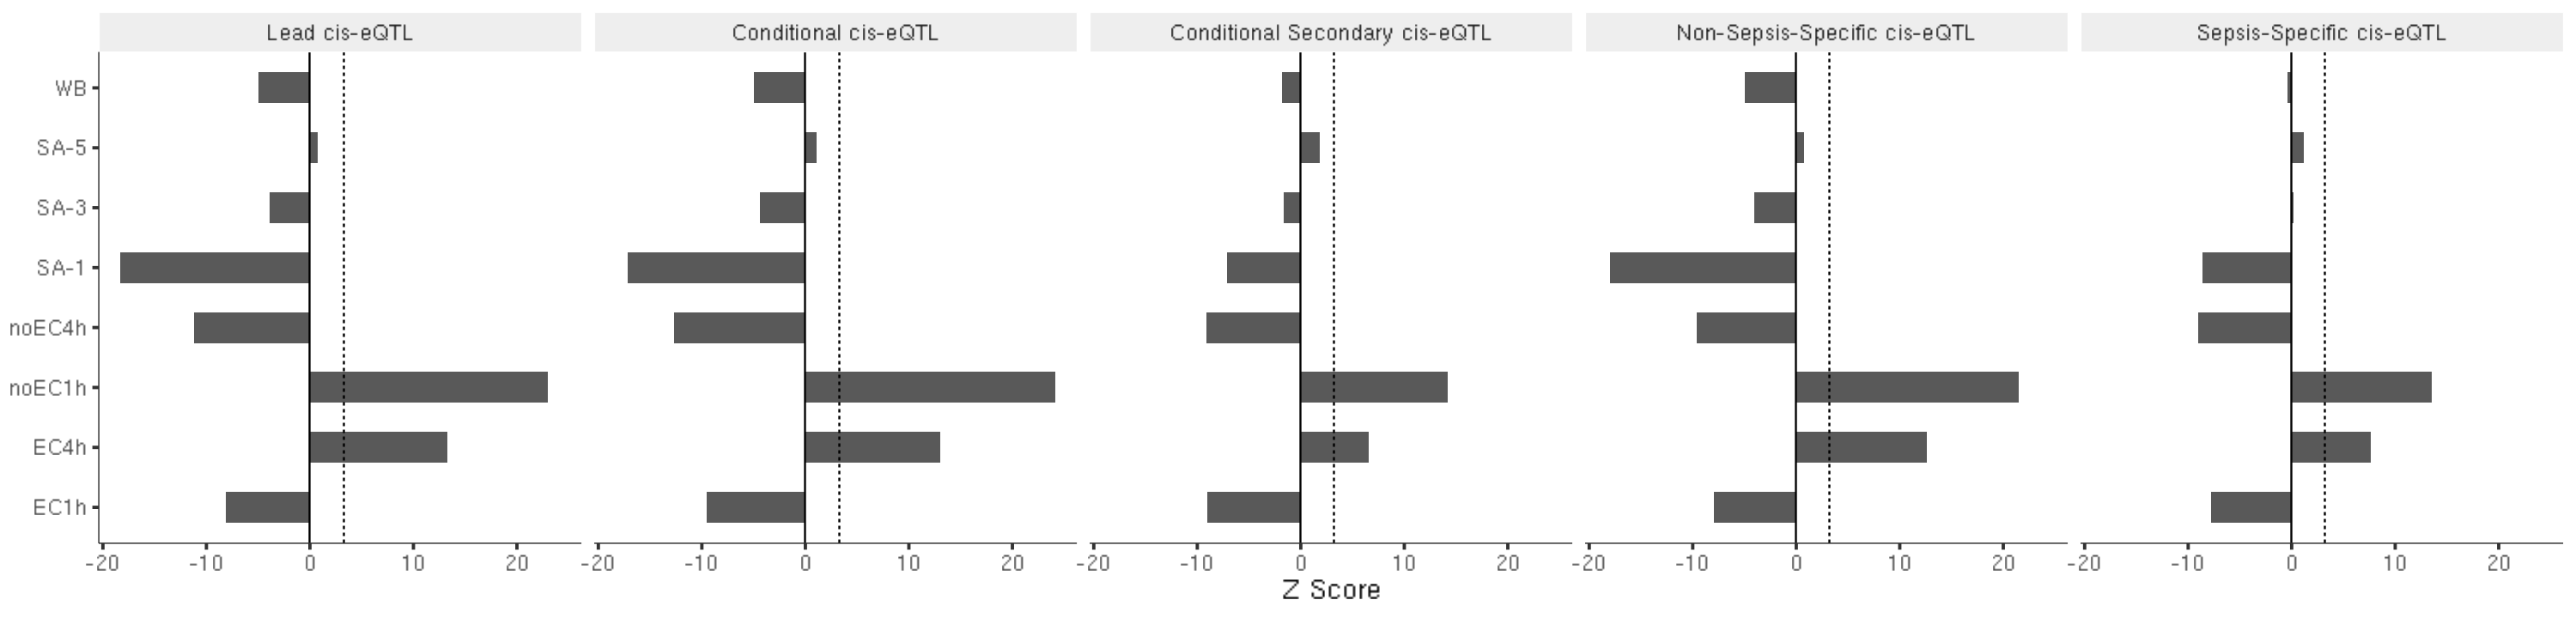

In [55]:
options(repr.plot.width=25, repr.plot.height=6)

merge(effects, p.vals, by=c("SNPs", "Condition")) %>%
    merge(., stat.info, by="SNPs") %>%
    dplyr::mutate(SNPs=factor(SNPs, levels=c("Lead cis-eQTL", "Conditional cis-eQTL", "Conditional Secondary cis-eQTL", "Non-Sepsis-Specific cis-eQTL", "Sepsis-Specific cis-eQTL", "Sepsis-Specific Up cis-eQTL"))) %>%
    dplyr::mutate(Z=(Rank.Mean - Mean) / SD) %>%
    ggplot() + 
    geom_bar(aes(x=Condition, y=Z), stat="identity", width=0.5) +
    geom_hline(aes(yintercept=critical.value), lty=2) +
    geom_hline(aes(yintercept=0)) +
    facet_grid(. ~ SNPs, scale="free_y", space="free_y") +
    scale_fill_brewer(palette="Pastel1") +
    coord_flip() +
    ylab("Z Score") +
    ggplot_theme +
    theme(axis.title.y=element_blank(), strip.text.y=element_text(angle=0))

ggsave("03_Functional_Interpretation/results/cheers_ram_mohan_et_all_whole_organism_all.svg", width=25, height=6)

# Signal Association with ATAC-Seq Sample Quality

Since the pattern is repeated across various SNP lists, the sample quality of the ATAC-Seq samples may make it more likely for certain associations to come through because more peaks are being detected in those samples. Indeed, in my own processing of the data, I have noticed that sample quality is associated with specific cell types.

## Peaks Driving Cell-Type-Specific Enrichment

CHEERS works on cell-type-specificity scores for peaks. We can use these specificity scores to understand which peaks are driving the enrichment signal.

In [56]:
all.norm <- fread("~/gains_team282/epigenetics/enrichment/cheers/normalized/Neutrophil_Atlas_counts_normToMax_quantileNorm_euclideanNorm.txt") %>%
    as.data.frame() %>%
    dplyr::mutate(ID=paste0(chr, ":", start, "-", end))

rownames(all.norm) <- all.norm$ID

In [57]:
head(all.norm)

,chr,start,end,LTA,LPS,FLAG,R848,BGP,HMGB1,Control,ID
,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
chr1:10077-10696,chr1,10077,10696,0.4082,0.5805,0.2553,0.2630,0.3216,0.2756,0.4275,chr1:10077-10696
chr1:10908-11527,chr1,10908,11527,0.4219,0.2974,0.4137,0.4729,0.3549,0.3538,0.2959,chr1:10908-11527
chr1:12907-13526,chr1,12907,13526,0.4538,0.3088,0.3947,0.4164,0.2966,0.2768,0.4528,chr1:12907-13526
chr1:14210-14829,chr1,14210,14829,0.3918,0.3774,0.3686,0.4126,0.4147,0.2938,0.3737,chr1:14210-14829
chr1:15021-15640,chr1,15021,15640,0.4659,0.3588,0.3681,0.4187,0.3878,0.2661,0.3497,chr1:15021-15640
chr1:16068-16687,chr1,16068,16687,0.4666,0.3138,0.3951,0.5190,0.3115,0.2638,0.3027,chr1:16068-16687


In [58]:
plot.data <- all.norm %>%
    tidyr::gather("Condition", "Euclidean.Norm", -ID, -chr, -start, -end) %>%
    dplyr::mutate(Peak.Size = end - start)

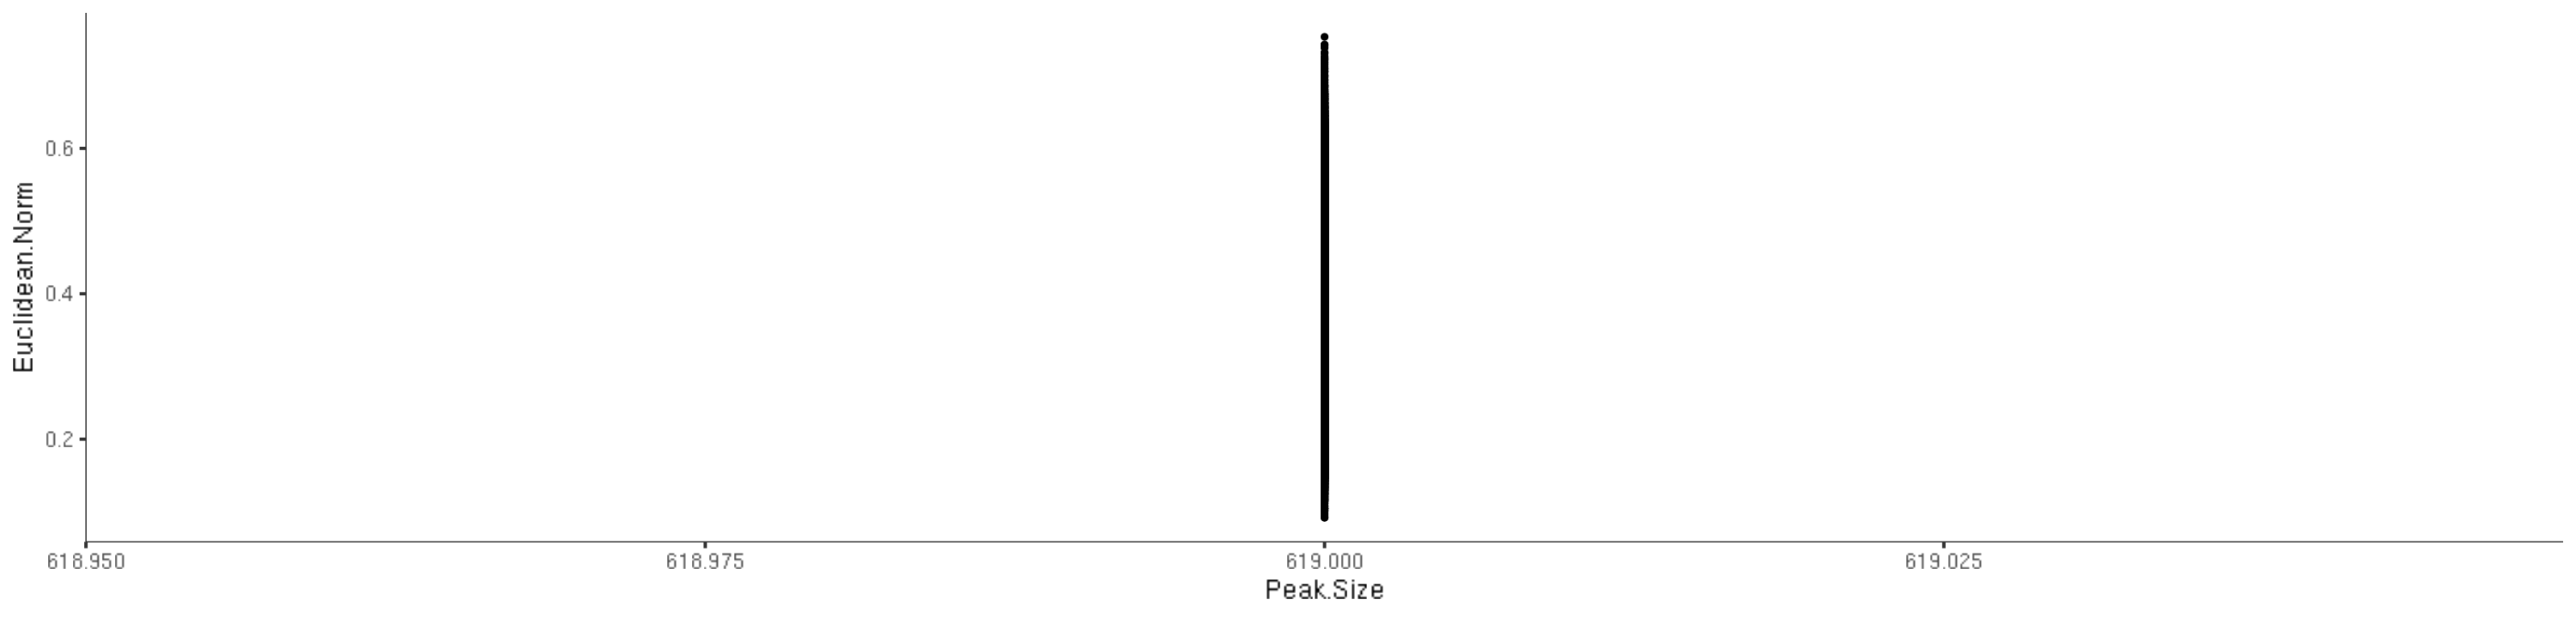

In [59]:
plot.data %>%
    ggplot() +
    geom_point(aes(x=Peak.Size, y=Euclidean.Norm)) +
    ggplot_theme

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



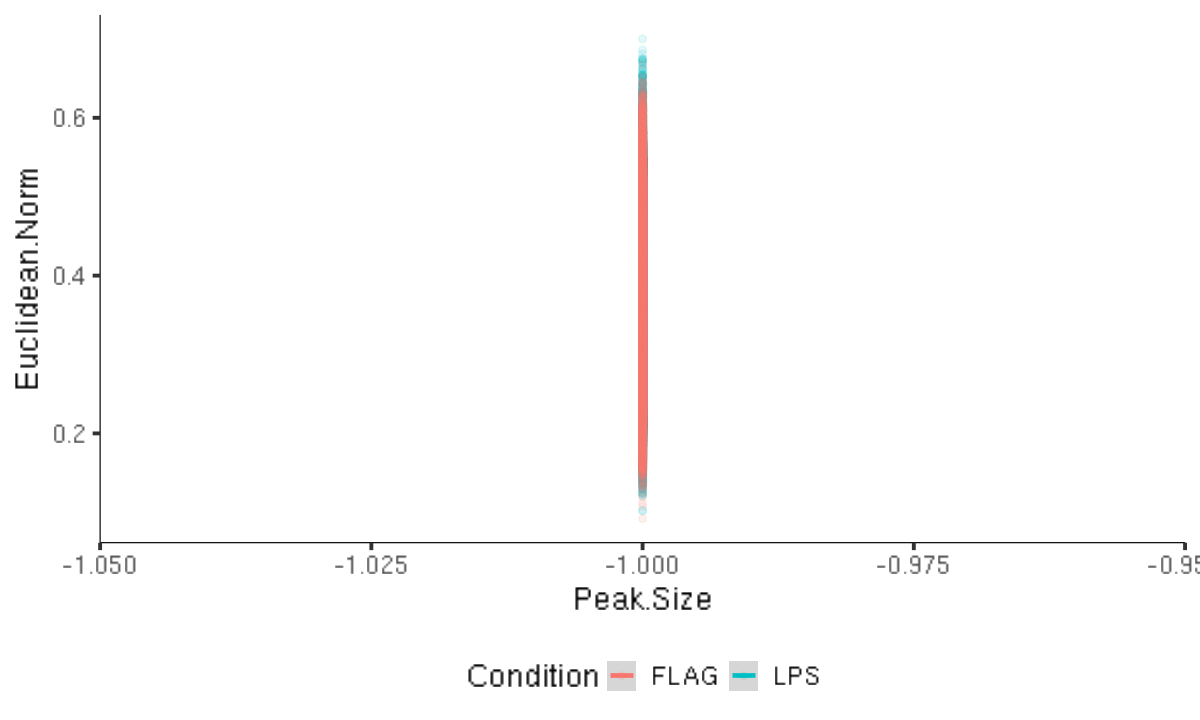

In [48]:
all.norm %>%
    tidyr::gather("Condition", "Euclidean.Norm", -ID, -chr, -start, -end) %>%
    dplyr::filter(Condition == "FLAG" | Condition == "LPS") %>%
    dplyr::mutate(Peak.Size = end - start) %>%
    ggplot(aes(color=Condition)) +
    geom_point(aes(x=Peak.Size, y=Euclidean.Norm), alpha=0.1) +
    geom_smooth(aes(x=Peak.Size, y=Euclidean.Norm)) +
    ggplot_theme